# Regional-average SST Skill (correlation & RMSE)

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import pandas as pd
import cftime
import copy
import scipy.stats
from scipy import signal
from functools import partial
import glob
import dask
import matplotlib.pyplot as plt
import xskillscore as xs
%matplotlib inline

# SMYLE Utility functions
from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import io_utils as io

## Create Dask Cluster

In [46]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
cluster.close()
client.close()

distributed.core - ERROR - Exception while handling op register-client
Traceback (most recent call last):
  File "/glade/work/xianwu/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/core.py", line 502, in handle_comm
    result = await result
  File "/glade/work/xianwu/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 5249, in add_client
    self.remove_client(client=client)
  File "/glade/work/xianwu/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 5276, in remove_client
    self.client_releases_keys(
  File "/glade/work/xianwu/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 5014, in client_releases_keys
    self.transitions(recommendations)
  File "/glade/work/xianwu/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 7119, in transitions
    self.send_all(client_msgs, worker_msgs)
  File "/glade/wor

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='P54048000',
        walltime='04:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks':True
    })
    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(30) 

In [4]:
cluster

# Data Intake

### Read in POP monthly SST field using I/O functions; Convert to seasonal mean

In [5]:
# This preprocessor will return POP SST (first vertical grid level only)
def preprocessor(d0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for your analysis to speed up processing. 
    
    Here,
        - reset monthly time to mid-month value
        - select top vertical level and only nlead time values
        - drop fields unrelated to SST
    """
    d0 = cal.time_set_midmonth(d0,'time')
    d0 = d0.isel(z_t=0).isel(time=slice(0, nlead))
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    d0 = d0[[field,'time','TLAT','TLONG','TAREA']].drop(['ULAT','ULONG'])
    d0 = d0.chunk({'L':-1})
    return d0

In [6]:
%%time
# SMYLE-Nov SST data
# process all 20 ensemble members, all November start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
#chunks={'z_t':1,'nlat':80}
smyle11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle11.nbytes/1e9 #GB

CPU times: user 21 s, sys: 11.3 s, total: 32.4 s
Wall time: 39.6 s


11.563509676

In [7]:
%%time
smyle11_seas = cal.mon_to_seas_dask(smyle11).persist()

CPU times: user 12 s, sys: 191 ms, total: 12.1 s
Wall time: 12.7 s


In [8]:
%%time
# SMYLE-Feb SST data
# process all 20 ensemble members, all February start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 2
#chunks={'z_t':1,'nlat':80}
smyle02 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle02.nbytes/1e9 #GB

CPU times: user 51 s, sys: 12.5 s, total: 1min 3s
Wall time: 1min 28s


11.563509676

In [9]:
smyle02_seas = cal.mon_to_seas_dask(smyle02).persist()

In [10]:
%%time
# SMYLE-May SST data
# process all 20 ensemble members, all May start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 5
#chunks={'z_t':1,'nlat':80}
smyle05 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle05.nbytes/1e9 #GB

CPU times: user 50.4 s, sys: 12.2 s, total: 1min 2s
Wall time: 1min 27s


11.563509676

In [11]:
smyle05_seas = cal.mon_to_seas_dask(smyle05).persist()

In [12]:
%%time
# SMYLE-Aug SST data
# process all 20 ensemble members, all August start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 8
#chunks={'z_t':1,'nlat':80}
smyle08 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle08.nbytes/1e9 #GB

CPU times: user 51.5 s, sys: 12.2 s, total: 1min 3s
Wall time: 1min 26s


11.563509676

In [13]:
smyle08_seas = cal.mon_to_seas_dask(smyle08).persist()

# Compute Regional-average SST

### Define Averaging Region

In [14]:
#lon-w, lon-e, lat-s, lat-n:
regionlonlat = [-170.,-120.,-5.,5.]  
regiontitle = 'Nino3.4'

#regionlonlat = [-20.,0.,-3.,3.]  
#regiontitle = 'Atlantic Nino'

#regionlonlat = [-80.,-10.,10.,20.]  
#regiontitle = 'Atlantic MDR'

#regionlonlat = [50.,70.,-10.,10.]    # IOD-west, to be overwritten by IOD
#regiontitle = 'Indian Ocean Dipole'

#regionlonlat = [90.,110.,-10.,0.]  # IOD-east
#regiontitle = 'IODe'

In [15]:
def POP_regional_areawgt(ds,lonlat):
    tarea = ds.TAREA
    tlat = ds.TLAT
    tlon = xr.where(ds.TLONG>180.,ds.TLONG-360.,ds.TLONG)
    region = (tlat>=lonlat[2]) & (tlat<=lonlat[3]) & (tlon>=lonlat[0]) & (tlon<=lonlat[1])
    return xr.where(region,tarea.fillna(0),0)

In [16]:
POPg16_regsst_area = POP_regional_areawgt(smyle11,regionlonlat)

### Perform computation on SMYLE, returning xarray:

In [17]:
%%time
smyle11_seas_time = smyle11_seas.time.load()
smyle02_seas_time = smyle02_seas.time.load()
smyle05_seas_time = smyle05_seas.time.load()
smyle08_seas_time = smyle08_seas.time.load()

CPU times: user 34.9 s, sys: 1.1 s, total: 36 s
Wall time: 1min 14s


In [18]:
%%time
smyle11_time = smyle11.time.load()
smyle02_time = smyle02.time.load()
smyle05_time = smyle05.time.load()
smyle08_time = smyle08.time.load()

CPU times: user 873 ms, sys: 37.7 ms, total: 910 ms
Wall time: 973 ms


In [19]:
%%time
smyle11_seas_regsst = smyle11_seas.TEMP.weighted(POPg16_regsst_area).mean(("nlon", "nlat")).load()
smyle02_seas_regsst = smyle02_seas.TEMP.weighted(POPg16_regsst_area).mean(("nlon", "nlat")).load()
smyle05_seas_regsst = smyle05_seas.TEMP.weighted(POPg16_regsst_area).mean(("nlon", "nlat")).load()
smyle08_seas_regsst = smyle08_seas.TEMP.weighted(POPg16_regsst_area).mean(("nlon", "nlat")).load()

CPU times: user 1min 37s, sys: 1.18 s, total: 1min 39s
Wall time: 1min 42s


In [20]:
%%time
smyle11_regsst = smyle11.TEMP.weighted(POPg16_regsst_area).mean(("nlon", "nlat")).load()
smyle02_regsst = smyle02.TEMP.weighted(POPg16_regsst_area).mean(("nlon", "nlat")).load()
smyle05_regsst = smyle05.TEMP.weighted(POPg16_regsst_area).mean(("nlon", "nlat")).load()
smyle08_regsst = smyle08.TEMP.weighted(POPg16_regsst_area).mean(("nlon", "nlat")).load()

CPU times: user 58.4 s, sys: 1.98 s, total: 1min
Wall time: 4min 12s


### Remove leadtime-dependent drift from SMYLE data:

In [21]:
%%time
# Remove leadtime-dependent drift (seasonal)
climy0 = 1972
climy1 = 2018
smyle11_seas_regsst_dd,smyle11_seas_regsst_drift = stat.remove_drift(smyle11_seas_regsst,smyle11_seas_time,climy0,climy1)
smyle02_seas_regsst_dd,smyle02_seas_regsst_drift = stat.remove_drift(smyle02_seas_regsst,smyle02_seas_time,climy0,climy1)
smyle05_seas_regsst_dd,smyle05_seas_regsst_drift = stat.remove_drift(smyle05_seas_regsst,smyle05_seas_time,climy0,climy1)
smyle08_seas_regsst_dd,smyle08_seas_regsst_drift = stat.remove_drift(smyle08_seas_regsst,smyle08_seas_time,climy0,climy1)


CPU times: user 9.77 ms, sys: 971 µs, total: 10.7 ms
Wall time: 10.7 ms


In [22]:
%%time
# Remove leadtime-dependent drift (monthly)
smyle11_regsst_dd,smyle11_regsst_drift = stat.remove_drift(smyle11_regsst,smyle11_time,climy0,climy1)
smyle02_regsst_dd,smyle02_regsst_drift = stat.remove_drift(smyle02_regsst,smyle02_time,climy0,climy1)
smyle05_regsst_dd,smyle05_regsst_drift = stat.remove_drift(smyle05_regsst,smyle05_time,climy0,climy1)
smyle08_regsst_dd,smyle08_regsst_drift = stat.remove_drift(smyle08_regsst,smyle08_time,climy0,climy1)

CPU times: user 11.9 ms, sys: 0 ns, total: 11.9 ms
Wall time: 11.9 ms


### Compute observed monthly and seasonal anomalies:

In [23]:
def obs_convert_mon_to_seas(da,field):
    """ Given a monthly xarray DataArray, convert to 
    seasonal averages and replace 'time' with 'year,season' dimensions."""
    season = xr.DataArray(['DJF','MAM','JJA','SON'],dims='season',name='season')
    da_group = cal.mon_to_seas(da).groupby('time.month')
    xrlist = []
    for i in [1,4,7,10]:
        tmp = da_group[i]
        tmp = tmp.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
        tmp = tmp.swap_dims({"time": "year"}).to_dataset(name=field)
        tmp = tmp.reset_coords(["time"])
        tmp["time"] = tmp.time.expand_dims("season")
        xrlist.append(tmp)
    da_seas = xr.concat(xrlist,dim=season)
    return da_seas

In [24]:
# Observed SST Index (NOAA ERSSTv5)
#ds_obs = xr.open_dataset('/glade/campaign/cesm/development/espwg/verification_datasets/mon/SST/ersst.v5.188001-202012.nc',decode_times=False)
#obs_time_vals = [cftime.DatetimeNoLeap(1880+year, 1+month, 15) for year in range(141) for month in range(12)]
#ds_obs['time'] = obs_time_vals
#obs_sst_tmp = ds_obs.sst.sel(lat=slice(regionlonlat[2],regionlonlat[3])).sel(lon=slice(360+regionlonlat[0],360+regionlonlat[1]))
#obs_wgts = np.cos(np.deg2rad(obs_sst_tmp.lat))
#obs_regsst = obs_sst_tmp.weighted(obs_wgts).mean(("lon", "lat")).load()

# HADISST  (1deg SST over ocean)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_obs = xr.open_dataset(obs_dir+'mon/SST/HadISST_sst.nc').sel(time=slice("1870","2020"))
nt = np.size(ds_obs.time)
obs_montime_vals = [cftime.DatetimeNoLeap(1870+year, 1+month, 15) for year in range(151) for month in range(12)]
ds_obs['time'] = obs_montime_vals
ds_obs['sst'] = xr.where(ds_obs['sst']<-2,-1.8,ds_obs['sst'])
ds_obs = ds_obs.sel(time=slice("1960","2020"))

# Note that latitude decreases with index in this dataset!
ds_obs = ds_obs.rename({"latitude":"lat","longitude":"lon"})

<xarray.Dataset>
Dimensions:  (year: 61, month: 12)
Coordinates:
  * year     (year) int64 1960 1961 1962 1963 1964 ... 2016 2017 2018 2019 2020
Dimensions without coordinates: month
Data variables:
    TEMP     (month, year) float32 0.05678 -0.118 -0.1971 ... 0.4896 -0.9961

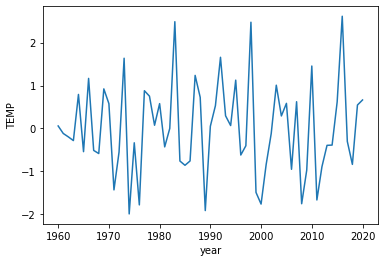

In [25]:
# Region
tmp = ds_obs.sst.sel(lat=slice(regionlonlat[3],regionlonlat[2])).sel(lon=slice(regionlonlat[0],regionlonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
obs_regsst = tmp.weighted(wgts).mean(("lon", "lat")).load()
obs_regsst_gb = obs_regsst.groupby('time.month')
obs_regsst = obs_regsst_gb - obs_regsst_gb.mean(dim='time')
xrlist2 = []
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    tmp2 = obs_regsst_gb[i]
    tmp2 = tmp2.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
    tmp2 = tmp2.swap_dims({"time": "year"}).to_dataset(name=field)
    tmp2 = tmp2.reset_coords(["time"])
    tmp2["time"] = tmp2.time.expand_dims("month")
    xrlist2.append(tmp2)
xrlist2
obs_regsst_12 = xr.concat(xrlist2,dim="month")
obs_regsst_12 = obs_regsst_12 - obs_regsst_12.mean("year")
obs_regsst_seas = obs_convert_mon_to_seas(obs_regsst,'sst')
obs_regsst_12.TEMP.isel(month=0).plot()
obs_regsst_12

### NMME forecast anomlies

In [26]:
#Decodes time dimension to CFTime standards."""
def decode_cf(ds, time_var):
    if ds[time_var].attrs['calendar'] == '360':
        ds[time_var].attrs['calendar'] = '360_day'
    ds = xr.decode_cf(ds, decode_times=True)
    return ds

In [27]:
%%time
# NMME Forecasts SST data
# process all 20 ensemble members, all November start dates from 1970-2018:
modelnames = ['CMC1-CanCM3', 'CMC2-CanCM4', 'COLA-RSMAS-CCSM4','GFDL-CM2p1-aer04',\
              'GFDL-CM2p5-FLOR-A06','GFDL-CM2p5-FLOR-B01','NASA-GMAO-062012','NCEP-CFSv2']
nmmelist = []
for i in range(8):
    field = 'sst'
    datadir = '/glade/work/xianwu/data/model/nmme/'    #The NMME SST data was from IRI
    casename = field+'-'+modelnames[i]
    filetemplate = datadir+casename+'.nc'
    ds_nmme = xr.open_dataset(filetemplate,decode_times=False)
    ds_nmme = ds_nmme.sel(S=slice('264','684'))   #198201(264)-201612(684)
    ds_nmme = decode_cf(ds_nmme, 'S')
    tmp_nmme = ds_nmme.sst.sel(Y=slice(regionlonlat[2],regionlonlat[3])).sel(X=slice(regionlonlat[0]+360,regionlonlat[1]+370))
    wgts_nmme = np.cos(np.deg2rad(tmp_nmme.Y))
    nmme_regsst = tmp_nmme.weighted(wgts_nmme).mean(("X", "Y")).load()   
    nmme_regsst
    print(i)
    #remove climatology
    if((modelnames[i] == 'COLA-RSMAS-CCSM4') | (modelnames[i] == 'NCEP-CFSv2')):   #two-period climatology definition for these two models according to Barnston et al. 2019
        sst1 = nmme_regsst.sel(S=slice('1982-01-01', '1998-12-01'))
        ssta1 = sst1.groupby('S.month') - sst1.groupby('S.month').mean(('S', 'M'))
        
        sst2 = nmme_regsst.sel(S=slice('1999-01-01', '2016-12-01'))
        ssta2 = sst2.groupby('S.month') - sst2.groupby('S.month').mean(('S', 'M'))
        nmme_regsst = xr.concat([ssta1, ssta2], dim='S')
    else:
        nmme_regsst = nmme_regsst.groupby('S.month') - nmme_regsst.groupby('S.month').mean(('S','M'))
    nmmelist.append(nmme_regsst)    

0
1
2
3
4
5
6
7
CPU times: user 4.59 s, sys: 6.78 s, total: 11.4 s
Wall time: 22 s


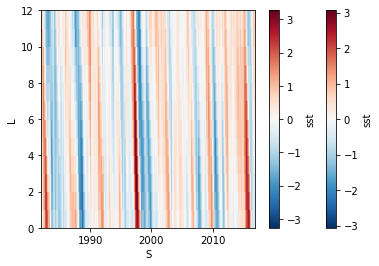

In [31]:
nmme_regsst_all = xr.concat(nmmelist,dim="model")
nmme_regsst_all.isel(model=2).mean('M').plot(x='S')
nmme_regsst_all.mean(('model','M')).plot(x='S')

In [32]:
nmme_regsst_all = nmme_regsst_all.rename({'S': 'year'})

month = nmme_regsst_all.year.month
year= nmme_regsst_all.year

#select the four start month as in SMYLE
timekeep = year.where((year.month == 11)).dropna('year')
nmme11_regsst_all = nmme_regsst_all.sel(year=timekeep)

timekeep = year.where((year.month == 2)).dropna('year')
nmme02_regsst_all = nmme_regsst_all.sel(year=timekeep)

timekeep = year.where((year.month == 5)).dropna('year')
nmme05_regsst_all = nmme_regsst_all.sel(year=timekeep)

timekeep = year.where((year.month == 8)).dropna('year')
nmme08_regsst_all = nmme_regsst_all.sel(year=timekeep)

In [33]:
nmme11_seas_regsst_all = cal.mon_to_seas_nmme(nmme11_regsst_all)
nmme02_seas_regsst_all = cal.mon_to_seas_nmme(nmme02_regsst_all)
nmme05_seas_regsst_all = cal.mon_to_seas_nmme(nmme05_regsst_all)
nmme08_seas_regsst_all = cal.mon_to_seas_nmme(nmme08_regsst_all)

nmme11_seas_regsst_all = nmme11_seas_regsst_all.rename({'L': 'season'})
nmme02_seas_regsst_all = nmme02_seas_regsst_all.rename({'L': 'season'})
nmme05_seas_regsst_all = nmme05_seas_regsst_all.rename({'L': 'season'})
nmme08_seas_regsst_all = nmme08_seas_regsst_all.rename({'L': 'season'})

nmme11_regsst_all = nmme11_regsst_all.rename({'L': 'months'})
nmme02_regsst_all = nmme02_regsst_all.rename({'L': 'months'})
nmme05_regsst_all = nmme05_regsst_all.rename({'L': 'months'})
nmme08_regsst_all = nmme08_regsst_all.rename({'L': 'months'})

# Plots

### Generate ACC and normalized RMSE Skill Plot

In [34]:
%%time
# Correlation as a function of forecast lead season:(1970-2018)
smyle11_seas_skill_reg = stat.leadtime_skill_seas(smyle11_seas_regsst_dd,smyle11_seas_time,obs_regsst_seas.sst,detrend=True)
smyle02_seas_skill_reg = stat.leadtime_skill_seas(smyle02_seas_regsst_dd,smyle02_seas_time,obs_regsst_seas.sst,detrend=True)
smyle05_seas_skill_reg = stat.leadtime_skill_seas(smyle05_seas_regsst_dd,smyle05_seas_time,obs_regsst_seas.sst,detrend=True)
smyle08_seas_skill_reg = stat.leadtime_skill_seas(smyle08_seas_regsst_dd,smyle08_seas_time,obs_regsst_seas.sst,detrend=True)
# Correlation as a function of forecast lead month:(1970-2018)
smyle11_mons_skill_reg = stat.leadtime_skill_mons(smyle11_regsst_dd,smyle11_time,obs_regsst_12.TEMP,detrend=True)
smyle02_mons_skill_reg = stat.leadtime_skill_mons(smyle02_regsst_dd,smyle02_time,obs_regsst_12.TEMP,detrend=True)
smyle05_mons_skill_reg = stat.leadtime_skill_mons(smyle05_regsst_dd,smyle05_time,obs_regsst_12.TEMP,detrend=True)
smyle08_mons_skill_reg = stat.leadtime_skill_mons(smyle08_regsst_dd,smyle08_time,obs_regsst_12.TEMP,detrend=True)

CPU times: user 2.07 s, sys: 4.95 ms, total: 2.08 s
Wall time: 2.18 s


In [35]:
%%time
# Correlation as a function of forecast lead season:(1982-2016)
smyle11_seas_skill_reg_short = stat.leadtime_skill_seas(smyle11_seas_regsst_dd.sel(Y=slice('1982','2016')),smyle11_seas_time.sel(Y=slice('1982','2016')),obs_regsst_seas.sst.sel(year=slice('1982','2016')),detrend=True)
smyle02_seas_skill_reg_short = stat.leadtime_skill_seas(smyle02_seas_regsst_dd.sel(Y=slice('1982','2016')),smyle02_seas_time.sel(Y=slice('1982','2016')),obs_regsst_seas.sst.sel(year=slice('1982','2016')),detrend=True)
smyle05_seas_skill_reg_short = stat.leadtime_skill_seas(smyle05_seas_regsst_dd.sel(Y=slice('1982','2016')),smyle05_seas_time.sel(Y=slice('1982','2016')),obs_regsst_seas.sst.sel(year=slice('1982','2016')),detrend=True)
smyle08_seas_skill_reg_short = stat.leadtime_skill_seas(smyle08_seas_regsst_dd.sel(Y=slice('1982','2016')),smyle08_seas_time.sel(Y=slice('1982','2016')),obs_regsst_seas.sst.sel(year=slice('1982','2016')),detrend=True)
# Correlation as a function of forecast lead month:(1982-2016)
smyle11_mons_skill_reg_short = stat.leadtime_skill_mons(smyle11_regsst_dd.sel(Y=slice('1982','2016')),smyle11_time.sel(Y=slice('1982','2016')),obs_regsst_12.TEMP.sel(year=slice('1982','2016')),detrend=True)
smyle02_mons_skill_reg_short = stat.leadtime_skill_mons(smyle02_regsst_dd.sel(Y=slice('1982','2016')),smyle02_time.sel(Y=slice('1982','2016')),obs_regsst_12.TEMP.sel(year=slice('1982','2016')),detrend=True)
smyle05_mons_skill_reg_short = stat.leadtime_skill_mons(smyle05_regsst_dd.sel(Y=slice('1982','2016')),smyle05_time.sel(Y=slice('1982','2016')),obs_regsst_12.TEMP.sel(year=slice('1982','2016')),detrend=True)
smyle08_mons_skill_reg_short = stat.leadtime_skill_mons(smyle08_regsst_dd.sel(Y=slice('1982','2016')),smyle08_time.sel(Y=slice('1982','2016')),obs_regsst_12.TEMP.sel(year=slice('1982','2016')),detrend=True)

CPU times: user 2.07 s, sys: 8.04 ms, total: 2.07 s
Wall time: 2.15 s


In [36]:
obs_regsst_seas_shift = obs_regsst_seas.sst.shift(year=-1)
obs_regsst_seas_new = xr.concat([obs_regsst_seas.sst.sel(year=slice('1982','2016')),obs_regsst_seas_shift.sel(year=slice('1982','2016'))],dim='season')


obs_regsst_12 = obs_regsst_12.rename({'month': 'months'})
obs_regsst_12_shift = obs_regsst_12.TEMP.shift(year=-1)
obs_regsst_12_new = xr.concat([obs_regsst_12.TEMP.sel(year=slice('1982','2016')),obs_regsst_12_shift.sel(year=slice('1982','2016'))],dim='months')
obs_regsst_12_new.sel(year=1983)

<xarray.DataArray 'TEMP' (months: 24)>
array([ 2.4874954 ,  2.2603512 ,  1.7624836 ,  1.1701031 ,  1.192997  ,
        0.64331055, -0.09111977, -0.10941505, -0.45323944, -1.0268745 ,
       -1.1475353 , -0.9672432 , -0.7602825 , -0.50860214, -0.41978073,
       -0.56230736, -0.5785694 , -0.8849106 , -0.38355827, -0.38346672,
       -0.3110733 , -0.82888603, -1.1913071 , -1.5532513 ], dtype=float32)
Coordinates:
    year     int64 1983
Dimensions without coordinates: months

In [37]:
#prepare nmme arrays
nmme11_seas_regsst_all['year'] = obs_regsst_seas['year'].sel(year=slice('1982','2016'))
nmme02_seas_regsst_all['year'] = obs_regsst_seas['year'].sel(year=slice('1982','2016'))
nmme05_seas_regsst_all['year'] = obs_regsst_seas['year'].sel(year=slice('1982','2016'))
nmme08_seas_regsst_all['year'] = obs_regsst_seas['year'].sel(year=slice('1982','2016'))

nmme11_seas_regsst_all['season'] = obs_regsst_seas['season'].isel(season=[0,1,2])
nmme02_seas_regsst_all['season'] = obs_regsst_seas['season'].isel(season=[1,2,3])
nmme05_seas_regsst_all['season'] = obs_regsst_seas['season'].isel(season=[2,3,0])
nmme08_seas_regsst_all['season'] = obs_regsst_seas['season'].isel(season=[3,0,1])

In [38]:
nmme11_regsst_all['year'] = obs_regsst_12['year'].sel(year=slice('1982','2016'))
nmme02_regsst_all['year'] = obs_regsst_12['year'].sel(year=slice('1982','2016'))
nmme05_regsst_all['year'] = obs_regsst_12['year'].sel(year=slice('1982','2016'))
nmme08_regsst_all['year'] = obs_regsst_12['year'].sel(year=slice('1982','2016'))

nmme11_regsst_all['months'] = obs_regsst_12_new['months'].isel(months=[10,11,12,13,14,15,16,17,18,19,20,21])
nmme02_regsst_all['months'] = obs_regsst_12_new['months'].isel(months=[1,2,3,4,5,6,7,8,9,10,11,12])
nmme05_regsst_all['months'] = obs_regsst_12_new['months'].isel(months=[4,5,6,7,8,9,10,11,12,13,14,15])
nmme08_regsst_all['months'] = obs_regsst_12_new['months'].isel(months=[7,8,9,10,11,12,13,14,15,16,17,18])

In [39]:
#ACC
nmme11_seas_corr_reg = xs.pearson_r(obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[4,5,6]),nmme11_seas_regsst_all.mean('M').sel(year=slice('1982','2016')),dim='year',skipna=True)
nmme02_seas_corr_reg = xs.pearson_r(obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[1,2,3]),nmme02_seas_regsst_all.mean('M').sel(year=slice('1982','2016')),dim='year',skipna=True)
nmme05_seas_corr_reg = xs.pearson_r(obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[2,3,4]),nmme05_seas_regsst_all.mean('M').sel(year=slice('1982','2016')),dim='year',skipna=True)
nmme08_seas_corr_reg = xs.pearson_r(obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[3,4,5]),nmme08_seas_regsst_all.mean('M').sel(year=slice('1982','2016')),dim='year',skipna=True)

nmme11_seas_corr_reg_mean = xs.pearson_r(obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[4,5,6]),nmme11_seas_regsst_all.mean(('M','model')).sel(year=slice('1982','2016')),dim='year',skipna=True)
nmme02_seas_corr_reg_mean = xs.pearson_r(obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[1,2,3]),nmme02_seas_regsst_all.mean(('M','model')).sel(year=slice('1982','2016')),dim='year',skipna=True)
nmme05_seas_corr_reg_mean = xs.pearson_r(obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[2,3,4]),nmme05_seas_regsst_all.mean(('M','model')).sel(year=slice('1982','2016')),dim='year',skipna=True)
nmme08_seas_corr_reg_mean = xs.pearson_r(obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[3,4,5]),nmme08_seas_regsst_all.mean(('M','model')).sel(year=slice('1982','2016')),dim='year',skipna=True)

nmme11_mons_corr_reg = xs.pearson_r(obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[10,11,12,13,14,15,16,17,18,19,20,21]),nmme11_regsst_all.mean('M').sel(year=slice('1982','2016')),dim='year',skipna=True)
nmme02_mons_corr_reg = xs.pearson_r(obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[1,2,3,4,5,6,7,8,9,10,11,12]),nmme02_regsst_all.mean('M').sel(year=slice('1982','2016')),dim='year',skipna=True)
nmme05_mons_corr_reg = xs.pearson_r(obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[4,5,6,7,8,9,10,11,12,13,14,15]),nmme05_regsst_all.mean('M').sel(year=slice('1982','2016')),dim='year',skipna=True)
nmme08_mons_corr_reg = xs.pearson_r(obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[7,8,9,10,11,12,13,14,15,16,17,18]),nmme08_regsst_all.mean('M').sel(year=slice('1982','2016')),dim='year',skipna=True)

nmme11_mons_corr_reg_mean = xs.pearson_r(obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[10,11,12,13,14,15,16,17,18,19,20,21]),nmme11_regsst_all.mean(('M','model')).sel(year=slice('1982','2016')),dim='year',skipna=True)
nmme02_mons_corr_reg_mean = xs.pearson_r(obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[1,2,3,4,5,6,7,8,9,10,11,12]),nmme02_regsst_all.mean(('M','model')).sel(year=slice('1982','2016')),dim='year',skipna=True)
nmme05_mons_corr_reg_mean = xs.pearson_r(obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[4,5,6,7,8,9,10,11,12,13,14,15]),nmme05_regsst_all.mean(('M','model')).sel(year=slice('1982','2016')),dim='year',skipna=True)
nmme08_mons_corr_reg_mean = xs.pearson_r(obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[7,8,9,10,11,12,13,14,15,16,17,18]),nmme08_regsst_all.mean(('M','model')).sel(year=slice('1982','2016')),dim='year',skipna=True)

In [40]:
#Normalized RMSE
nmme11_seas_rmse_reg = xs.rmse(obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[4,5,6]),nmme11_seas_regsst_all.mean('M').sel(year=slice('1982','2016')),dim='year',skipna=True)/obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[4,5,6]).std('year')
nmme02_seas_rmse_reg = xs.rmse(obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[1,2,3]),nmme02_seas_regsst_all.mean('M').sel(year=slice('1982','2016')),dim='year',skipna=True)/obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[1,2,3]).std('year')
nmme05_seas_rmse_reg = xs.rmse(obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[2,3,4]),nmme05_seas_regsst_all.mean('M').sel(year=slice('1982','2016')),dim='year',skipna=True)/obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[2,3,4]).std('year')
nmme08_seas_rmse_reg = xs.rmse(obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[3,4,5]),nmme08_seas_regsst_all.mean('M').sel(year=slice('1982','2016')),dim='year',skipna=True)/obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[3,4,5]).std('year')

nmme11_seas_rmse_reg_mean = xs.rmse(obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[4,5,6]),nmme11_seas_regsst_all.mean(('M','model')).sel(year=slice('1982','2016')),dim='year',skipna=True)/obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[4,5,6]).std('year')
nmme02_seas_rmse_reg_mean = xs.rmse(obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[1,2,3]),nmme02_seas_regsst_all.mean(('M','model')).sel(year=slice('1982','2016')),dim='year',skipna=True)/obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[1,2,3]).std('year')
nmme05_seas_rmse_reg_mean = xs.rmse(obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[2,3,4]),nmme05_seas_regsst_all.mean(('M','model')).sel(year=slice('1982','2016')),dim='year',skipna=True)/obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[2,3,4]).std('year')
nmme08_seas_rmse_reg_mean = xs.rmse(obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[3,4,5]),nmme08_seas_regsst_all.mean(('M','model')).sel(year=slice('1982','2016')),dim='year',skipna=True)/obs_regsst_seas_new.sel(year=slice('1982','2016')).isel(season=[3,4,5]).std('year')

nmme11_mons_rmse_reg = xs.rmse(obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[10,11,12,13,14,15,16,17,18,19,20,21]),nmme11_regsst_all.mean('M').sel(year=slice('1982','2016')),dim='year',skipna=True)/obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[10,11,12,13,14,15,16,17,18,19,20,21]).std('year')
nmme02_mons_rmse_reg = xs.rmse(obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[1,2,3,4,5,6,7,8,9,10,11,12]),nmme02_regsst_all.mean('M').sel(year=slice('1982','2016')),dim='year',skipna=True)/obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[1,2,3,4,5,6,7,8,9,10,11,12]).std('year')
nmme05_mons_rmse_reg = xs.rmse(obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[4,5,6,7,8,9,10,11,12,13,14,15]),nmme05_regsst_all.mean('M').sel(year=slice('1982','2016')),dim='year',skipna=True)/obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[4,5,6,7,8,9,10,11,12,13,14,15]).std('year')
nmme08_mons_rmse_reg = xs.rmse(obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[7,8,9,10,11,12,13,14,15,16,17,18]),nmme08_regsst_all.mean('M').sel(year=slice('1982','2016')),dim='year',skipna=True)/obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[7,8,9,10,11,12,13,14,15,16,17,18]).std('year')

nmme11_mons_rmse_reg_mean = xs.rmse(obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[10,11,12,13,14,15,16,17,18,19,20,21]),nmme11_regsst_all.mean(('M','model')).sel(year=slice('1982','2016')),dim='year',skipna=True)/obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[10,11,12,13,14,15,16,17,18,19,20,21]).std('year')
nmme02_mons_rmse_reg_mean = xs.rmse(obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[1,2,3,4,5,6,7,8,9,10,11,12]),nmme02_regsst_all.mean(('M','model')).sel(year=slice('1982','2016')),dim='year',skipna=True)/obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[1,2,3,4,5,6,7,8,9,10,11,12]).std('year')
nmme05_mons_rmse_reg_mean = xs.rmse(obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[4,5,6,7,8,9,10,11,12,13,14,15]),nmme05_regsst_all.mean(('M','model')).sel(year=slice('1982','2016')),dim='year',skipna=True)/obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[4,5,6,7,8,9,10,11,12,13,14,15]).std('year')
nmme08_mons_rmse_reg_mean = xs.rmse(obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[7,8,9,10,11,12,13,14,15,16,17,18]),nmme08_regsst_all.mean(('M','model')).sel(year=slice('1982','2016')),dim='year',skipna=True)/obs_regsst_12_new.sel(year=slice('1982','2016')).isel(months=[7,8,9,10,11,12,13,14,15,16,17,18]).std('year')

In [41]:
nmme11_mons_corr_reg['months']=range(12)
nmme02_mons_corr_reg['months']=range(12)
nmme05_mons_corr_reg['months']=range(12)
nmme08_mons_corr_reg['months']=range(12)

nmme11_mons_corr_reg_mean['months']=range(12)
nmme02_mons_corr_reg_mean['months']=range(12)
nmme05_mons_corr_reg_mean['months']=range(12)
nmme08_mons_corr_reg_mean['months']=range(12)

nmme11_seas_corr_reg['season']=([ 1, 4, 7])
nmme02_seas_corr_reg['season']=([ 1, 4, 7])
nmme05_seas_corr_reg['season']=([ 1, 4, 7])
nmme08_seas_corr_reg['season']=([ 1, 4, 7])

nmme11_seas_corr_reg_mean['season']=([ 1, 4, 7])
nmme02_seas_corr_reg_mean['season']=([ 1, 4, 7])
nmme05_seas_corr_reg_mean['season']=([ 1, 4, 7])
nmme08_seas_corr_reg_mean['season']=([ 1, 4, 7])

nmme11_mons_rmse_reg['months']=range(12)
nmme02_mons_rmse_reg['months']=range(12)
nmme05_mons_rmse_reg['months']=range(12)
nmme08_mons_rmse_reg['months']=range(12)

nmme11_mons_rmse_reg_mean['months']=range(12)
nmme02_mons_rmse_reg_mean['months']=range(12)
nmme05_mons_rmse_reg_mean['months']=range(12)
nmme08_mons_rmse_reg_mean['months']=range(12)

nmme11_seas_rmse_reg['season']=([ 1, 4, 7])
nmme02_seas_rmse_reg['season']=([ 1, 4, 7])
nmme05_seas_rmse_reg['season']=([ 1, 4, 7])
nmme08_seas_rmse_reg['season']=([ 1, 4, 7])

nmme11_seas_rmse_reg_mean['season']=([ 1, 4, 7])
nmme02_seas_rmse_reg_mean['season']=([ 1, 4, 7])
nmme05_seas_rmse_reg_mean['season']=([ 1, 4, 7])
nmme08_seas_rmse_reg_mean['season']=([ 1, 4, 7])

In [42]:
# combine skill score xarrays for plotting
startmonth= xr.DataArray([11,2,5,8],name='startmonth',dims='startmonth')
reg_seas_skill = xr.concat([smyle02_seas_skill_reg,smyle05_seas_skill_reg,smyle08_seas_skill_reg,smyle11_seas_skill_reg],dim=startmonth)
reg_seas_skill['regiontitle'] = regiontitle
reg_mons_skill = xr.concat([smyle02_mons_skill_reg,smyle05_mons_skill_reg,smyle08_mons_skill_reg,smyle11_mons_skill_reg],dim=startmonth)
reg_mons_skill = reg_mons_skill.mean('startmonth')

startmonth= xr.DataArray([11,2,5,8],name='startmonth',dims='startmonth')
reg_seas_skill_short = xr.concat([smyle02_seas_skill_reg_short,smyle05_seas_skill_reg_short,smyle08_seas_skill_reg_short,smyle11_seas_skill_reg_short],dim=startmonth)
reg_seas_skill_short['regiontitle'] = regiontitle

reg_mons_skill_short = xr.concat([smyle02_mons_skill_reg_short,smyle05_mons_skill_reg_short,smyle08_mons_skill_reg_short,smyle11_mons_skill_reg_short],dim=startmonth)
reg_mons_skill_short = reg_mons_skill_short.mean('startmonth')
reg_mons_skill_short

<xarray.Dataset>
Dimensions:  (L: 24)
Coordinates:
    z_t      float32 500.0
  * L        (L) int64 0 1 2 3 4 5 6 7 8 9 10 ... 14 15 16 17 18 19 20 21 22 23
Data variables:
    corr     (L) float64 0.9684 0.9302 0.9097 0.8938 ... 0.2912 0.2873 0.2264
    pval     (L) float64 5.247e-17 1.01e-10 7.999e-10 ... 0.1679 0.163 0.2507
    nrmse    (L) float64 0.2455 0.3594 0.4405 0.472 ... 1.028 1.019 1.017 1.052
    msss     (L) float64 0.9359 0.8519 0.7896 ... -0.04045 -0.03637 -0.1079
    rpc      (L) float64 0.9701 0.9457 0.9481 0.9555 ... 0.5087 0.5224 0.4306

In [43]:
# combine seasonal skill score xarrays for plotting
startmonth= xr.DataArray([11,2,5,8],name='startmonth',dims='startmonth')
reg_seas_acc_nmme = xr.concat([nmme02_seas_corr_reg,nmme05_seas_corr_reg,nmme08_seas_corr_reg,nmme11_seas_corr_reg],dim=startmonth)
reg_mons_acc_nmme = xr.concat([nmme02_mons_corr_reg,nmme05_mons_corr_reg,nmme08_mons_corr_reg,nmme11_mons_corr_reg],dim=startmonth)
reg_seas_acc_nmme_mean = xr.concat([nmme02_seas_corr_reg_mean,nmme05_seas_corr_reg_mean,nmme08_seas_corr_reg_mean,nmme11_seas_corr_reg_mean],dim=startmonth)
reg_mons_acc_nmme_mean = xr.concat([nmme02_mons_corr_reg_mean,nmme05_mons_corr_reg_mean,nmme08_mons_corr_reg_mean,nmme11_mons_corr_reg_mean],dim=startmonth)

reg_seas_rmse_nmme = xr.concat([nmme02_seas_rmse_reg,nmme05_seas_rmse_reg,nmme08_seas_rmse_reg,nmme11_seas_rmse_reg],dim=startmonth)
reg_mons_rmse_nmme = xr.concat([nmme02_mons_rmse_reg,nmme05_mons_rmse_reg,nmme08_mons_rmse_reg,nmme11_mons_rmse_reg],dim=startmonth)
reg_seas_rmse_nmme_mean = xr.concat([nmme02_seas_rmse_reg_mean,nmme05_seas_rmse_reg_mean,nmme08_seas_rmse_reg_mean,nmme11_seas_rmse_reg_mean],dim=startmonth)
reg_mons_rmse_nmme_mean = xr.concat([nmme02_mons_rmse_reg_mean,nmme05_mons_rmse_reg_mean,nmme08_mons_rmse_reg_mean,nmme11_mons_rmse_reg_mean],dim=startmonth)

# Plots

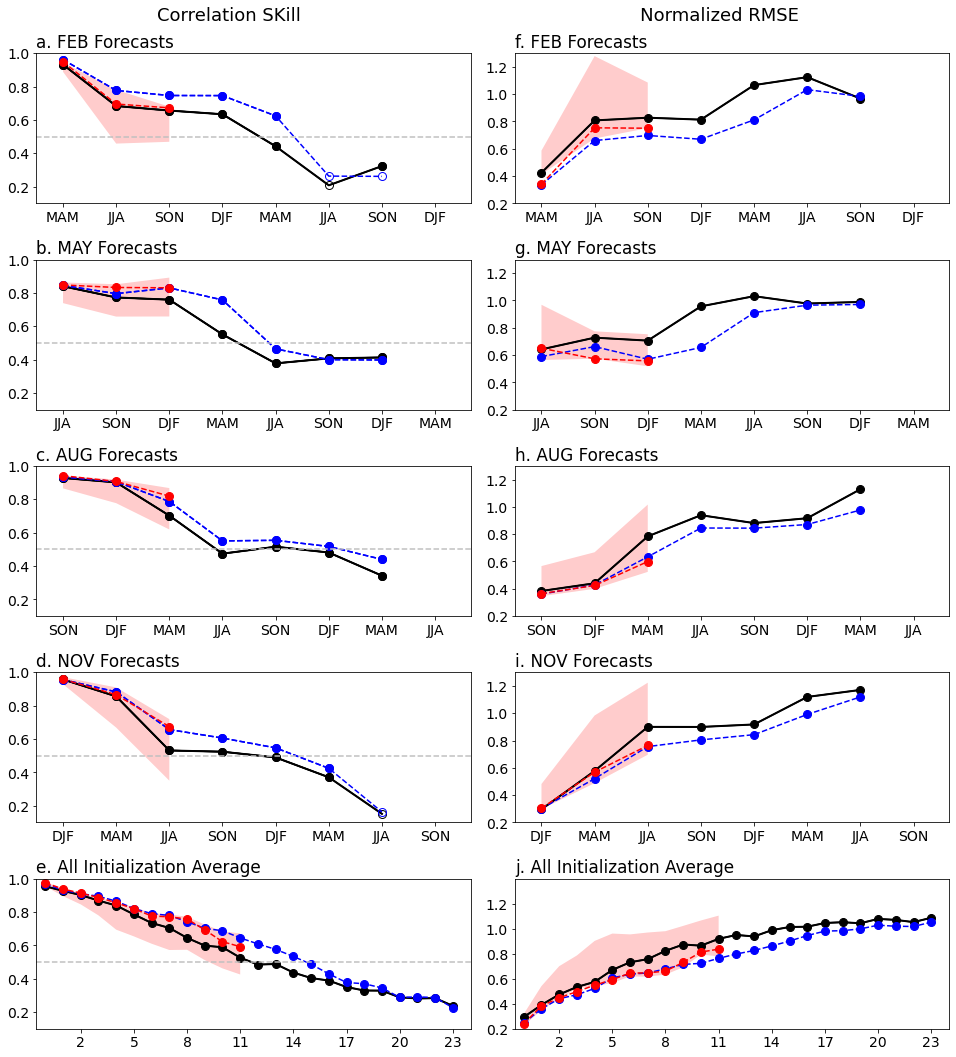

In [45]:
# plot skill scores
fig = plt.figure(figsize=(18*0.75,20*0.75))
plt.rcParams['font.size'] = '14'
leadsea = smyle11_seas_skill_reg.L
leadmon = smyle11_mons_skill_reg.L
seasons = ['DJF','MAM','JJA','SON']
xsea = [['MAM','JJA','SON','DJF','MAM','JJA','SON'],\
        ['JJA','SON','DJF','MAM','JJA','SON','DJF'],\
        ['SON','DJF','MAM','JJA','SON','DJF','MAM'],\
        ['DJF','MAM','JJA','SON','DJF','MAM','JJA']]
markers = ['D','o','s','P']
colors = ['k','r','g','b']
hindcasts = ['FEB Forecasts','MAY Forecasts','AUG Forecasts','NOV Forecasts','All Initialization Average']
figlabs = [['a.','b.','c.','d.','e.'],['f.','g.','h.','i.','j.']]

ncol = 2
nrow = 5

i=0
    #ax.set_title('Correlation',loc='center')
for j in range(4):
    ax = fig.add_subplot(nrow,ncol,j*2+1+i)
    ax.set_title(figlabs[0][j]+' '+ hindcasts[j],loc='left')
    
    ax.plot(leadsea,reg_seas_skill.isel(startmonth=j).corr,color='k',linewidth=2)
    #1970-2018 SMYLE
    tmp = reg_seas_skill.isel(startmonth=j)
    ax.plot(leadsea,tmp.corr,color='k',marker='o',markersize=8,fillstyle='none')
    ax.plot(leadsea,tmp.corr.where(tmp.pval<0.1),color='k',marker='o',markersize=8)
    #1982-2016 SMYLE
    tmp = reg_seas_skill_short.isel(startmonth=j)
    ax.plot(leadsea,tmp.corr,color='b',marker='o',linestyle='dashed',markersize=8,fillstyle='none')
    ax.plot(leadsea,tmp.corr.where(tmp.pval<0.1),color='b',linestyle='dashed',marker='o',markersize=8)
    #1982-2016 NMME
    tmp = reg_seas_acc_nmme_mean.isel(startmonth=j)
    ax.plot(leadsea.isel(L=slice(0,3)),tmp,color='r',markersize=8,marker='o',linestyle='dashed')
    ymin = reg_seas_acc_nmme.isel(startmonth=j).min('model')
    ymax = reg_seas_acc_nmme.isel(startmonth=j).max('model')
    ax.fill_between(leadsea.isel(L=slice(0,3)),ymin,ymax,fc='r',alpha=0.2)
    
    ax.set_xticks(leadsea)
    ax.set_xticklabels(reg_seas_skill.season[j].values)
    #ax.set_xticks(xsea[j])
    ax.set_xlim([-0.5,24])
    ax.set_ylim([0.1,1])
    ax.axhline(y=0.5, color="silver", linestyle="--")

for j in range(4,5):
    ax = fig.add_subplot(nrow,ncol,j*2+1+i)
    ax.set_title(figlabs[0][j]+' '+ hindcasts[j],loc='left')
    ax.plot(leadmon,reg_mons_skill.corr,color='k',linewidth=2)
    #1970-2018
    tmp = reg_mons_skill
    ax.plot(leadmon,tmp.corr,color='k',marker='o',markersize=8)
    
    #1982-2016
    tmp = reg_mons_skill_short
    ax.plot(leadmon,tmp.corr,color='b',linestyle='dashed',marker='o',markersize=8)
    
    #1982-2016 NMME
    tmp = reg_mons_acc_nmme_mean.mean('startmonth')
    ax.plot(leadmon.isel(L=slice(0,12)),tmp,color='r',markersize=8,marker='o',linestyle='dashed')
    ymin = reg_mons_acc_nmme.mean('startmonth').min('model')
    ymax = reg_mons_acc_nmme.mean('startmonth').max('model')
    ax.fill_between(leadmon.isel(L=slice(0,12)),ymin,ymax,fc='r',alpha=0.2)
    
    ax.set_xticks(leadmon[2::3])
    ax.set_xlim([-0.5,24])
    ax.set_ylim([0.1,1])
    ax.axhline(y=0.5, color="silver", linestyle="--")  

    
i=1
#ax.set_title('Normalized RMSE',loc='center')
for j in range(4):
    ax = fig.add_subplot(nrow,ncol,j*2+1+i)
    ax.set_title(figlabs[1][j]+' '+ hindcasts[j],loc='left')
    ax.plot(leadsea,reg_seas_skill.isel(startmonth=j).nrmse,color='k',linewidth=2)
    #1970-2018
    tmp = reg_seas_skill.isel(startmonth=j)
    ax.plot(leadsea,tmp.nrmse,color='k',marker='o',markersize=8)
    
    #1982-2016
    tmp = reg_seas_skill_short.isel(startmonth=j)
    ax.plot(leadsea,tmp.nrmse,color='b',linestyle='dashed',marker='o',markersize=8)        

    #1982-2016 NMME
    tmp = reg_seas_rmse_nmme_mean.isel(startmonth=j)
    ax.plot(leadsea.isel(L=slice(0,3)),tmp,color='r',markersize=8,marker='o',linestyle='dashed')
    ymin = reg_seas_rmse_nmme.isel(startmonth=j).min('model')
    ymax = reg_seas_rmse_nmme.isel(startmonth=j).max('model')
    ax.fill_between(leadsea.isel(L=slice(0,3)),ymin,ymax,fc='r',alpha=0.2)
    
    ax.set_xticks(leadsea)
    #ax.set_xticklabels(xsea[j])
    ax.set_xticklabels(reg_seas_skill.season[j].values)
    ax.set_xlim([-0.5,24])
    ax.set_ylim([0.2,1.3])
    ax.set_yticks(np.arange(0.2, 1.4, 0.2))

for j in range(4,5):
    ax = fig.add_subplot(nrow,ncol,j*2+1+i)
    ax.set_title(figlabs[1][j]+' '+ hindcasts[j],loc='left')
    ax.plot(leadmon,reg_mons_skill.nrmse,color='k',linewidth=2)
    #1970-2018
    tmp = reg_mons_skill
    ax.plot(leadmon,tmp.nrmse,color='k',marker='o',markersize=8)
    
    #1982-2016
    tmp = reg_mons_skill_short
    ax.plot(leadmon,tmp.nrmse,color='b',linestyle='dashed',marker='o',markersize=8)
    
    #1982-2016 NMME
    tmp = reg_mons_rmse_nmme_mean.mean('startmonth')
    ax.plot(leadmon.isel(L=slice(0,12)),tmp,color='r',markersize=8,marker='o',linestyle='dashed')
    ymin = reg_mons_rmse_nmme.mean('startmonth').min('model')
    ymax = reg_mons_rmse_nmme.mean('startmonth').max('model')
    ax.fill_between(leadmon.isel(L=slice(0,12)),ymin,ymax,fc='r',alpha=0.2)
    
    ax.set_xticks(leadmon[2::3])
    ax.set_xlim([-0.5,24])
    ax.set_ylim([0.2,1.4])
    ax.set_yticks(np.arange(0.2, 1.4, 0.2))
fig.suptitle('Correlation SKill                                                           Normalized RMSE',fontsize=18)    
fig.tight_layout()    
plt.savefig('Fig03_index_ACC_RMSE_NMME_seasonal_monthly.png')